In [1]:
# essential
import numpy as np
np.random.seed(67) 

import os

# keras
import keras
import keras.backend as K
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Activation, Flatten, Dropout
from keras.initializers import RandomNormal
from keras.engine.topology import Layer, InputSpec
from keras.optimizers import SGD
from keras.callbacks import LearningRateScheduler
from keras.losses import CategoricalCrossentropy

#sklearn
from sklearn.preprocessing import normalize
# from sklearn.utils.linear_assignment_ import linear_assignment
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

# visualization
import matplotlib.pyplot as plt
from dipy.viz import actor, window

# others
import utils.bundleTools3 as bt3
import utils.bundleTools as bt
import time
from dipy.segment.metric import mdf
from dipy.segment.clustering import QuickBundles
import pickle
import hdbscan
from collections import defaultdict
from MulticoreTSNE import MulticoreTSNE as TSNE
import random
import time


Using TensorFlow backend.
/home/fondecyt-1190701/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/fondecyt-1190701/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/fondecyt-1190701/anaconda3/envs/python36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16",

In [2]:
import utils.bundleTools3 as bt3
import numpy as np
from dipy.viz import actor, window
from IPython.display import clear_output
import random
import hdbscan
from collections import defaultdict
import time
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from joblib import Memory
from dipy.segment.metric import mdf
import keras
%matplotlib inline

def display_og(streamlines, clusters=False, ids=False, colors=False, hd=False):
    ren = window.Renderer()
    ren.background((1, 1, 1))
    if clusters:
        colormap = actor.create_colormap(np.arange(len(ids)))#, name='hot')
        #print(colormap)
        #random.shuffle(colormap)
        stream = []
        colors = []
        num = 0
        for i,id_ in enumerate(ids):
            for streamline in clusters[id_]:
                stream.append(streamlines[streamline])
                colors.append(colormap[num]*len(streamlines[streamline]))
            num+=1
        if(hd):
            ren.add(actor.streamtube(stream, colors))
        else:
            ren.add(actor.line(stream, colors))
            
    else:
        if colors:
            ren.add(actor.line(streamlines, colors))
        else:
            ren.add(actor.line(streamlines))
    
    window.show(ren, size=(1200, 900))


def display(streamlines, clusters=False, ids=False, hd=False, color = 'tab20'):
    ren = window.Renderer()
    ren.background((1, 1, 1))
    if(clusters):
        colormap = actor.create_colormap(np.arange(len(ids)), name=color, auto=True)
        #colormap = actor.create_colormap(np.arange(int(len(ids)/2)+1), name='tab20', auto=True)
        #colormap = [*colormap[:-1],*colormap[:-1], colormap[-1]]

        stream = []
        colors = []

        for i,id_ in enumerate(ids):
            for streamline in clusters[id_]:
                stream.append(streamlines[streamline])
                colors.append(colormap[i])#*len(streamlines[streamline]))
        if(hd):
            ren.add(actor.streamtube(stream, linewidth=0.1, colors=colors))
        else:
            ren.add(actor.line(stream, colors))
            
    else:
        if(hd):
            #ren.add(actor.line(streamlines, window.colors.black, opacity=0.05))
            ren.add(actor.streamtube(streamlines, linewidth=0.1, colors=[(0.4,0.698,1)]*len(streamlines)))
        else:
            ren.add(actor.line(streamlines))

    window.show(ren, size=(1200, 900))
    
def colormap_display(clustered_streamlines, clusters_dict, n):
    ren = window.Renderer()
    ren.background((1, 1, 1))
    
    sizes = [0]*(len(clusters_dict.keys())-1)
    for i in clusters_dict.keys():
        if i == -1:
            continue
        sizes[i] = len(clusters_dict[i])
    sizes = np.argsort(sizes)[-n:]

    colormap = actor.create_colormap(np.arange(len(sizes)), name='PuBu')
    streamlines = []
    colors = []
    num=0
    
    for num,i in enumerate(sizes):
        ids_ = clusters_dict[i]
        all_f = np.concatenate(clustered_streamlines[ids_])
        colors += [colormap[num]]*len(all_f)
        streamlines.append(all_f)

    ren.add(actor.line(np.concatenate(streamlines), colors, opacity=0.01))
    #ren.add(actor.line(np.concatenate(clustered_streamlines)[::500], [(0,0,0)]*10702, opacity=0.05))
    window.show(ren, size=(1500, 1100))

def weighted_display(streamlines, weights, clusters, ids):
    ren = window.Renderer()
    ren.background((1, 1, 1))

    colormap = actor.create_colormap(np.arange(len(ids)))#, name='hot')

    stream = []
    colors = []
    num = 0

    weights = np.array(weights)
    xmax, xmin = weights.max(), weights.min()
    weights = (weights - xmin)/((xmax - xmin))
    for i,id_ in enumerate(ids):
        for streamline in clusters[id_]:
            color=colormap[num]*len(streamlines[streamline])
            ren.add(actor.streamtube([streamlines[streamline]], color, linewidth=weights[streamline]))
        num+=1

    window.show(ren, size=(1200, 900))
    
def clustered_display(clustered_streamlines, clusters_dict, ids, sample=0, subjects=[]):
    ren = window.Renderer()
    ren.background((1, 1, 1))

    colormap = actor.create_colormap(np.arange(len(ids)))
    streamlines = []
    colors = []
    num=0
    for i,id_ in enumerate(ids):
        if len(subjects):
            all_f = clustered_streamlines[clusters_dict[id_]]
            sub_ids = subjects[clusters_dict[id_]]
            colormap = actor.create_colormap(np.arange(len(set(sub_ids))))
            count = 0
            last = sub_ids[0]
            for sid, clus in zip(sub_ids, all_f):
                if sid != last:
                    count += 1
                    last = sid
                colors += [colormap[count]*10000]*len(clus)
                streamlines.append(clus)
        else:
            all_f = np.concatenate(clustered_streamlines[clusters_dict[id_]])
            if sample:
                fibers = random.sample(list(all_f), int(len(all_f)*(sample/100)))
            else:
                fibers = np.concatenate(clustered_streamlines[clusters_dict[id_]])
            streamlines.append(fibers)
            lenin = len(fibers)
            colors += [colormap[i]*10000] * lenin
    ren.add(actor.line(np.concatenate(streamlines), colors))
    window.show(ren, size=(1200, 900))

def adjusted_clustered_display(clustered_streamlines, all_centroids, weights, clusters_dict, ids,sample=0):
    ren = window.Renderer()
    ren.background((1, 1, 1))

    colormap = actor.create_colormap(np.arange(len(ids)))
    streamlines = []
    colors = []
    num=0
    for i,id_ in enumerate(ids):
        centroids = all_centroids[clusters_dict[id_]]
        super_centroid = get_centroid(centroids, weights=weights[clusters_dict[id_]])
        clusters = clustered_streamlines[clusters_dict[id_]]
        lenin = 0
        for cluster_fibers, centroid in zip(clusters, centroids):
            all_f = adjust(super_centroid, centroid, cluster_fibers)
            if sample:
                all_f = random.sample(list(all_f), int(len(all_f)*(sample/100)))                
                
            lenin += len(all_f)
            streamlines.append(all_f)
            
        colors += [colormap[i]*10000] * lenin
    ren.add(actor.line(np.concatenate(streamlines), colors))
    window.show(ren, size=(1200, 900))

def clustered_display_brain(clustered_streamlines, clusters_dict, ids, sample=0, subjects=[]):
    ren = window.Renderer()
    ren.background((1, 1, 1))

    colormap = actor.create_colormap(np.arange(len(ids)))
    streamlines = []
    colors = []
    num=0
    for i,id_ in enumerate(ids):
        all_f = clustered_streamlines[clusters_dict[id_]]
        sub_ids = subjects[clusters_dict[id_]]
        count = 0
        last = sub_ids[0]
        for sid, clus in zip(sub_ids, all_f):
            if sid != last:
                count += 1
                last = sid
            colors += [colormap[0]*30]*len(clus)
            streamlines.append(clus)
    ren.add(actor.streamtube(np.concatenate(streamlines), colors, linewidth=0.3))
    ren.add(actor.line(np.concatenate(clustered_streamlines)[::500], [(0,0,0)]*10702, opacity=0.05))
    window.show(ren, size=(1500, 1100))

def clustered_display_delayed(clustered_streamlines, clusters_dict, ids, sample=0, subjects=[]):
    ren = window.Renderer()
    ren.background((1, 1, 1))

    colormap = actor.create_colormap(np.arange(len(ids)))
    streamlines = []
    colors = []
    num=0
    for i,id_ in enumerate(ids):
        all_f = clustered_streamlines[clusters_dict[id_]]
        sub_ids = subjects[clusters_dict[id_]]
        count = 0
        last = sub_ids[0]
        for sid, clus in zip(sub_ids, all_f):
            if sid != last:
                count += 1
                last = sid
            colors += [colormap[0]*30]*len(clus)
            streamlines.append(clus+count*100)
    ren.add(actor.line(np.concatenate(streamlines), colors))
    window.show(ren, size=(1500, 1100))
    
def adjust(super_centroid, centroid, cluster_fibers):
    normal = np.linalg.norm(super_centroid - centroid)
    flipped = np.linalg.norm(super_centroid - np.flip(centroid, axis=0))
    if flipped < normal:
        centroid = np.flip(centroid, axis=0)
    delta = super_centroid - centroid
    ret = []
    for fiber in cluster_fibers:
        normal = np.linalg.norm(centroid - fiber)
        flipped = np.linalg.norm(centroid - np.flip(fiber, axis=0))
        if flipped < normal:
            fiber = np.flip(fiber, axis=0)
        ret.append(fiber + delta)
    return ret
def load_data(path, file_format='bundle'):
    print('loading ', end='')
    if file_format == 'bundle': 
        data = np.array(bt3.read_bundle_severalbundles(path)[0][0])
    else:
        data = np.load(path)
    print('size: ', len(data))
    # normalize to 0-1
    print('normalizing...')
    #xmax, xmin = data.max(), data.min()
    xmin, xmax = -89.88333, 114.81356
    data = (data - xmin)/(xmax - xmin)
    #print('orientation...')
    for i, fiber in enumerate(data):
        if np.mean(fiber[0]) > np.mean(fiber[-1]):
            data[i] = np.flip(data[i], axis=0)
    return data
def get_centroid(cluster, weights=[]):
    for i, fiber in enumerate(cluster):
        if i == 0:
            first = fiber
        else:
            normal = np.linalg.norm(fiber - first)
            flipped = np.linalg.norm(np.flip(fiber, axis=0) - first)
            if flipped < normal:
                cluster[i] = np.flip(cluster[i], axis=0)
    if len(weights) > 0:
        total = sum(weights)
        centroid = [[0]*3]*21
        for fiber, w in zip(cluster, weights):
            centroid += fiber * w/total
        return centroid
    return np.mean(np.array(cluster), axis=0)

def get_centroids(brain, sub, remove_little_ones=False, size=False, nearest=False):
    centroids = []
    original_data = []
    
    og_centroids = np.array(bt3.read_bundle_severalbundles(path + sub + '/Talairach/centroids_Tal.bundles')[0])
    
    if(remove_little_ones):
        removed1 = 0
        removed2 = 0
        for i,cluster in enumerate(brain):
            sz = len(cluster)
            if(sz >= remove_little_ones):
                centroid = og_centroids[i][0]
                #centroid = get_centroid(cluster)
                if np.linalg.norm(centroid[0]-centroid[1]) > size:
                    centroids.append(centroid)
                    selected = random.sample(range(sz),int(sz*(nearest/100)))
                    original_data.append(np.array(cluster)[selected])
                else:
                    removed2 +=1
            else:
                removed1+=1
        print(str(removed1)+' and '+str(removed2)+' removed from '+str(len(brain))+'. '+str(len(centroids))+' remaining centroids.'+str(len(np.concatenate(brain)))+' remaining fibers')
    else:
        for cluster in brain:
            centroids.append(get_centroid(cluster))
            original_data.append(np.array(cluster))
    return centroids, np.array(original_data)

from dipy.segment.metric import mdf
import keras.backend as K
def mdf_loss(y_true, y_pred):
    normal = K.sqrt(K.sum(K.square(y_pred - y_true), axis=-1))
    inverted = K.sqrt(K.sum(K.square(y_pred - K.reverse(y_true,axes=0)), axis=-1))
    loss=K.minimum(K.sum(normal)/21,K.sum(inverted)/21)
    return loss

byte_order = "DCBA"

def random_palette(n):
    return [(random.randrange(0, 255), random.randrange(0, 255), random.randrange(0, 255)) for i in range(n)]

def write_hie(path,names,colors):
    f = open(path,"w")
    f.write("# tree 1.0\n\n*BEGIN TREE hierarchy\ngraph_syntax RoiArg\n\n*BEGIN TREE fold_name\nname ALL\n\n")
    for i,n in enumerate(names):
        f.write("*BEGIN TREE fold_name\n")
        f.write("name "+n+"\n")
        f.write("color "+str(colors[i][0])+" "+str(colors[i][1])+" "+str(colors[i][2])+"\n\n")
        f.write("*END\n\n")
    f.write("*END\n\n*END\n\n*END\n\n")
    f.close()


def write_header(path,bnames,intervals,dim,nfibers):
    f = open(path,"w")
    f.write("attributes = {\n    'binary' : 1,\n    'bundles' : ")
    f.write(str([val for pair in zip(bnames, intervals) for val in pair])+",\n")
    f.write("    'byte_order' : "+'\''+byte_order+'\',\n')
    f.write("    'curves_count' : "+str(nfibers)+",\n")
    f.write("    'data_file_name' : "+"\'*"+os.path.splitext(path+"data")[1]+"\',\n")
    f.write("    'format' : 'bundles_1.0',\n")
    f.write("    'space_dimension' : "+str(dim)+"\n  }")
    f.close()

def write_data(data_path,bundles,dim):
    f = open(data_path,"wb")
    for b in bundles:
        for fiber in b:
            f.write(np.array([len(fiber)],dtype=np.int32).tostring())
            f.write(fiber.ravel().tostring())
    f.close()

def write_bundles(path,bundles,bnames=None,colors=None):
    if bnames == None:
        bnames = [''+str(i)+'' for i in range(len(bundles))]
    bnames = [''+n.strip()+'' for n in bnames]
    data_path = path+"data"
    dim = len(bundles[0][0][0])
    nfibers = sum(len(b) for b in bundles)
    intervals = [0]
    for i in range(1,len(bundles),1):
        intervals.append(intervals[i-1]+len(bundles[i-1])) 

    write_header(path,bnames,intervals,dim,nfibers)
    write_data(data_path,bundles,dim)
    if colors == None:
        colors = random_palette(len(bnames))
    write_hie(os.path.splitext(path)[0]+".hie",bnames,colors)

In [36]:
path = 'data/79subjects/clustered_2/'

all_centroids = []
ids = []
all_data = []
for i in range(1,80):
    
    if i < 10:
        name = '00' + str(i)
    else:
        name = '0' + str(i)
    
    data = np.array(bt3.read_bundle_severalbundles(path + name + '/Talairach/finalClusters_tal.bundles')[0])
    centroids, data = get_centroids(data, name, 15, 1.5, 100)
    all_centroids.append(centroids)
    all_data.append(data)
    ids += [i]*len(data)
print('saving all_data...')
np.save(path+'filtered/all_centroids', np.concatenate(all_centroids))
np.save(path+'filtered/ids', np.array(ids))
# np.save(path+'filtered/all_data', np.concatenate(all_data))

data/79subjects/clustered_2/001/Talairach/finalClusters_tal.bundlesdata
data/79subjects/clustered_2/001/Talairach/centroids_Tal.bundlesdata
19013 and 0 removed from 28240. 9227 remaining centroids.552791 remaining fibers
data/79subjects/clustered_2/002/Talairach/finalClusters_tal.bundlesdata
data/79subjects/clustered_2/002/Talairach/centroids_Tal.bundlesdata
19351 and 4 removed from 28613. 9258 remaining centroids.582900 remaining fibers
data/79subjects/clustered_2/003/Talairach/finalClusters_tal.bundlesdata
data/79subjects/clustered_2/003/Talairach/centroids_Tal.bundlesdata
20465 and 4 removed from 31015. 10546 remaining centroids.680796 remaining fibers
data/79subjects/clustered_2/004/Talairach/finalClusters_tal.bundlesdata
data/79subjects/clustered_2/004/Talairach/centroids_Tal.bundlesdata
21014 and 7 removed from 31197. 10176 remaining centroids.649954 remaining fibers
data/79subjects/clustered_2/005/Talairach/finalClusters_tal.bundlesdata
data/79subjects/clustered_2/005/Talairach/

data/79subjects/clustered_2/038/Talairach/finalClusters_tal.bundlesdata
data/79subjects/clustered_2/038/Talairach/centroids_Tal.bundlesdata
16937 and 2 removed from 25727. 8788 remaining centroids.533724 remaining fibers
data/79subjects/clustered_2/039/Talairach/finalClusters_tal.bundlesdata
data/79subjects/clustered_2/039/Talairach/centroids_Tal.bundlesdata
17847 and 1 removed from 27390. 9542 remaining centroids.617938 remaining fibers
data/79subjects/clustered_2/040/Talairach/finalClusters_tal.bundlesdata
data/79subjects/clustered_2/040/Talairach/centroids_Tal.bundlesdata
23924 and 7 removed from 35326. 11395 remaining centroids.748925 remaining fibers
data/79subjects/clustered_2/041/Talairach/finalClusters_tal.bundlesdata
data/79subjects/clustered_2/041/Talairach/centroids_Tal.bundlesdata
18479 and 7 removed from 28046. 9560 remaining centroids.608199 remaining fibers
data/79subjects/clustered_2/042/Talairach/finalClusters_tal.bundlesdata
data/79subjects/clustered_2/042/Talairach/c

data/79subjects/clustered_2/075/Talairach/centroids_Tal.bundlesdata
18982 and 4 removed from 28669. 9683 remaining centroids.615302 remaining fibers
data/79subjects/clustered_2/076/Talairach/finalClusters_tal.bundlesdata
data/79subjects/clustered_2/076/Talairach/centroids_Tal.bundlesdata
20728 and 12 removed from 31800. 11060 remaining centroids.719944 remaining fibers
data/79subjects/clustered_2/077/Talairach/finalClusters_tal.bundlesdata
data/79subjects/clustered_2/077/Talairach/centroids_Tal.bundlesdata
15202 and 3 removed from 23029. 7824 remaining centroids.476218 remaining fibers
data/79subjects/clustered_2/078/Talairach/finalClusters_tal.bundlesdata
data/79subjects/clustered_2/078/Talairach/centroids_Tal.bundlesdata
17749 and 4 removed from 26541. 8788 remaining centroids.545978 remaining fibers
data/79subjects/clustered_2/079/Talairach/finalClusters_tal.bundlesdata
data/79subjects/clustered_2/079/Talairach/centroids_Tal.bundlesdata
15928 and 3 removed from 24622. 8691 remaining

# Loading autoencoder and encoder

In [3]:
from keras.layers import Bidirectional, LSTM, RepeatVector

In [41]:
from keras.layers import Reshape

inputs = Input(shape=(21, 3))

encoder = LSTM(128, return_sequences=True)(inputs)
encoder = LSTM(64, return_sequences=True)(encoder)
encoder = LSTM(7, return_sequences=False)(encoder)

decoder = RepeatVector(21)(encoder)

decoder = LSTM(64, return_sequences=True)(decoder)
decoder = LSTM(128, return_sequences=True)(decoder)
decoder = LSTM(3, return_sequences=True)(decoder)

sequence_encoder = Model(inputs, encoder)
sequence_autoencoder = Model(inputs, decoder)
sequence_autoencoder.summary()

sequence_autoencoder.compile(loss="mse",optimizer='adam', metrics=['acc'])

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 21, 3)             0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 21, 128)           67584     
_________________________________________________________________
lstm_8 (LSTM)                (None, 21, 64)            49408     
_________________________________________________________________
lstm_9 (LSTM)                (None, 7)                 2016      
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 21, 7)             0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 21, 64)            18432     
_________________________________________________________________
lstm_11 (LSTM)               (None, 21, 128)           9881

In [42]:
import os

checkpoints_path = 'checkpoints/'

sequence_autoencoder.load_weights(checkpoints_path + 'autoencoder_79subjects_7latent_isaias.h5')
sequence_encoder.load_weights(checkpoints_path + 'encoder_79subjects_7latent_isaias.h5')

In [3]:
import os
from keras.models import load_model

checkpoints_path = 'checkpoints/'

sequence_autoencoder = load_model(checkpoints_path + 'autoencoder_79subjects_7latent_mdfloss.h5', custom_objects = {'mdf_loss': mdf_loss})

sequence_encoder = keras.Model(inputs=sequence_autoencoder.input,
                                       outputs=sequence_autoencoder.layers[4].input)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



# Loading filtered (data, centroids, ids)

In [37]:
#Save all_data
data_path = 'data/79subjects/clustered_2/filtered'

for i in range(1,9):
    low = int(10*(i-1))
    high = int(10*i)
    
    np.save(data_path + '/all_data_' + str(i) + '.npy', all_data[low:high])

In [78]:
#Load all_data
data_path = 'data/79subjects/clustered_2/filtered'

all_centroids = np.load(data_path + '/all_centroids.npy')
ids = np.load(data_path + '/ids.npy')

all_data = np.empty((0))

for i in range(1,9):
    new_data = np.load(data_path + '/all_data_' + str(i) + '.npy', allow_pickle = True)
    for j in range(len(new_data)):
        all_data = np.concatenate((all_data,new_data[j]))
#     all_data = np.concatenate((all_data,new_data))

In [46]:
total_len = 0

for i in range(len(all_data)):
    for j in range(len(all_data[i])):
        total_len += len(all_data[i][j])

In [51]:
print('Hay ' + str(len(ids)) + ' clústers')
print('Correspondientes a ' + str(total_len) + ' fibras')

Hay 768937 clústers
Correspondientes a 39350398 fibras


# Codificación de centroides a espacio latente

In [56]:
t0 = time.time()
latent = sequence_encoder.predict(all_centroids)
print('Tiempo de codificación: ' + str(time.time() - t0) + '[s]')

Tiempo de codificación: 165.14008116722107[s]


In [57]:
np.save(data_path + '/latent_centroids_isaias.npy', latent)

In [4]:
latent = np.load(data_path + '/latent_centroids_isaias.npy')

NameError: name 'data_path' is not defined

In [58]:
latent.shape

(768937, 7)

# HDBSCAN MODIFICADO

In [59]:
def diversity_score(clusters_dict, ids):
    n_non_noise = len(ids) - len(clusters_dict[-1])
    n_clusters = len(clusters_dict.keys())-1
    n_fibers_per_cluster = n_non_noise/n_clusters
    
    if n_clusters < 800:
        return 0
    
    penalty = abs(800 - n_clusters)
    subjects = len(set(ids))
    diversity_score = 0
    
    a = range(1,n_clusters)
    a = random.sample(a,800)
    for i in a:#range(1,n_clusters):
        uniq = len(set(ids[clusters_dict[i]]))
        #full_size = len(clusters_dict[i])
        diversity_score += uniq
    return diversity_score /79
    #return diversity_score / (79 * (n_clusters+penalty))

def robust_score(clusters_dict, ids):
    '''hist = [0]*79
    for i in clusters_dict.keys():
        hist[len(set(ids[clusters_dict[i]]))-1] +=1
    
    robust = np.logspace(1, 10, num=79, base=2)
    robust = robust/robust.max()
    
    robust = robust * hist
    robust = sum(robust)/len(clusters_dict.keys())
    '''
    robust = 0
    for i in clusters_dict.keys():
        if (len(clusters_dict[i]) >= 79):
            robust += 79
        else:
            robust += abs(len(clusters_dict[i])-79)
    
    robust = robust / (79*len(clusters_dict.keys()))
    return 1 - robust

def score(clusters_dict, ids):
    ds = diversity_score(clusters_dict, ids)
    rs = robust_score(clusters_dict, ids)
    return 2*((ds*rs)/(ds+rs))

def other(clusters_dict, ids):
    hist = [0]*79
    for i in clusters_dict.keys():
        hist[len(set(ids[clusters_dict[i]]))-1] +=1
        
    if (len(clusters_dict.keys()) < 1000):
        penalty = 1000 - len(clusters_dict.keys())
    else:
        penalty = 0
        
    hist = np.array(hist)
    hist = hist/(len(clusters_dict.keys()) + penalty)
    #robust = np.logspace(1, 10, num=79, base=2)-2
    robust = np.array(range(79))
    #robust = robust/robust.max()
    
    robust = robust * hist
    
    robust = sum(robust)/79
    
    

    return robust

def other2(clusters_dict, ids):
    hist = [0]*79
    for i in clusters_dict.keys():
        hist[len(set(ids[clusters_dict[i]]))-1] +=1
        
    hist = np.array(hist)
    hist = hist/(len(clusters_dict.keys()))
    #robust = np.logspace(1, 10, num=79, base=2)-2
    robust = np.array(range(79))
    #robust = robust/robust.max()
    
    robust = robust * hist
    
    robust = sum(robust)/79
    
    

    return robust

In [60]:
print('min_samples', 'min_cluster_size', 'time', 'n_clusters', 'noise_fibers', 'diversity_score', 'robust_score', 'score','other')

location = './cachedir'
memory = Memory(location, verbose=0)
ds = []
n_clus = []
n_noise = []
scorem = []
robustm = []
penalty_score = []
for i, ms in enumerate([1,2,3,4,5]):
    ds_ = []
    n_clus_ = []
    n_noise_ = []
    score_ = []
    robust_ = []
    penalty_score_ = []
    for j, mcs in enumerate([10,15,20,25,30,35,40,45,50,55,60,65,70,79]):
        
        clusterer = hdbscan.HDBSCAN(
            algorithm='boruvka_kdtree',
            cluster_selection_method='leaf',
            min_samples=ms,
            min_cluster_size=mcs, 
            alpha=1.0,
            core_dist_n_jobs = 4,
            memory=memory)

        t0 = time.time()
        clusterer.fit(latent, ids)
        exe_time = time.time() - t0
        
        clusters_dict = defaultdict(list)
        for k, clus in enumerate(clusterer.labels_):
            clusters_dict[clus].append(k)
        n = len(set(clusters_dict))
        ds_.append(diversity_score(clusters_dict, ids))
        n_clus_.append(n)
        n_noise_.append(len(clusters_dict[-1]))
        #score_.append(score(clusters_dict, ids))
        robust_.append(robust_score(clusters_dict, ids))
        penalty_score_.append(other(clusters_dict,ids))
        
        print(ms, mcs, exe_time, n, len(clusters_dict[-1]), diversity_score(clusters_dict, ids), robust_score(clusters_dict, ids), other(clusters_dict, ids))
    ds.append(ds_)
    n_clus.append(n_clus_)
    n_noise.append(n_noise_)
    #scorem.append(score_)
    robustm.append(robust_)
    penalty_score.append(penalty_score_)

min_samples min_cluster_size time n_clusters noise_fibers diversity_score robust_score score other
1 10 326.947128534317 13727 522274 131.29113924050634 0.2251849584068356 0.15033754966881313
1 15 8.864635229110718 7422 559360 181.34177215189874 0.3303572342232637 0.21929330863768007
1 20 6.820460319519043 4792 577391 236.53164556962025 0.403557617125589 0.2843135183111092
1 25 5.843472003936768 3474 588270 286.8354430379747 0.43806796236782464 0.3409049503363138
1 30 5.291277885437012 2746 594766 326.0126582278481 0.4487954861847382 0.3869748402740004
1 35 4.854236125946045 2188 599149 358.2151898734177 0.439300673408465 0.43569064864739754
1 40 4.581105947494507 1847 602942 387.3164556962025 0.42088093590015974 0.4731449562410479
1 45 4.386401891708374 1565 603163 422.69620253164555 0.38450277025114243 0.5134711044607111
1 50 4.241687774658203 1360 600572 450.43037974683546 0.343596425912137 0.5495253164556962
1 55 4.114482641220093 1206 602023 469.67088607594934 0.2967441274639461 0

/home/fondecyt-1190701/anaconda3/envs/python36/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


2 10 306.4251673221588 10071 580669 134.58227848101265 0.23175831344290976 0.15361440104372875
2 15 7.778840065002441 5523 602866 196.15189873417722 0.3338306781537277 0.22706426749358846
2 20 6.264604806900024 3656 613573 248.22784810126583 0.39621361105725283 0.2926384233997174
2 25 5.496352910995483 2716 620677 288.11392405063293 0.42672116478067146 0.347402173710408
2 30 5.114140748977661 2120 624253 328.1012658227848 0.43524002866013856 0.3991103415333175
2 35 4.7616307735443115 1741 625086 363.6835443037975 0.42465773344287805 0.4442449050814677
2 40 4.5522239208221436 1480 622121 395.40506329113924 0.40017105713308243 0.48489565514881994
2 45 4.443081855773926 1269 621041 428.4810126582278 0.36255997446409516 0.5245832959272226
2 50 4.245243549346924 1088 622368 458.253164556962 0.3121626023827252 0.5649432241250932
2 55 4.152286529541016 975 622679 488.36708860759495 0.26079844206426483 0.5818987341772149
2 60 4.033097743988037 886 624052 509.43037974683546 0.20984655827642373 

/home/fondecyt-1190701/anaconda3/envs/python36/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


3 10 305.2351634502411 7203 623775 139.7594936708861 0.24068909403079242 0.16195431931491272
3 15 6.776499271392822 4119 636763 197.126582278481 0.3390462844305948 0.23558317276222263
3 20 5.642584323883057 2812 641277 253.49367088607596 0.3962223382609792 0.30231197219871436
3 25 5.052388668060303 2127 642776 299.34177215189874 0.4196021019680658 0.35983408021043495
3 30 4.702562570571899 1700 643844 332.73417721518985 0.4238644825018615 0.408361876396128
3 35 4.5165886878967285 1396 641440 375.0253164556962 0.4052265061114939 0.45754597221718485
3 40 4.284440517425537 1178 640494 410.9620253164557 0.3775010208248265 0.5034063312630288
3 45 4.218407869338989 1030 639175 442.44303797468353 0.34327147597394614 0.5400024579083201
3 50 4.096426010131836 909 634721 472.54430379746833 0.29934132653771706 0.5233544303797469
3 55 4.132779598236084 839 633925 492.7088607594937 0.26125133899609243 0.503632911392405
3 60 4.098010778427124 757 632695 0 0.2045883985753223 0.4766835443037974
3 65 3

/home/fondecyt-1190701/anaconda3/envs/python36/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


4 10 311.79964423179626 5595 649010 145.74683544303798 0.24891573624732755 0.1695184443614891
4 15 5.813372611999512 3291 655613 206.873417721519 0.33983745466154336 0.245710395439807
4 20 5.028836488723755 2295 656013 265.9113924050633 0.3859297868233088 0.31517056893080697
4 25 4.790356159210205 1760 654915 306.67088607594934 0.40378308400460294 0.3736262945914844
4 30 4.537096261978149 1405 652159 350.45569620253167 0.4020090995089869 0.4302175773683498
4 35 4.1672141551971436 1172 650316 396.56962025316454 0.3913358102561887 0.47626042251695677
4 40 4.0674989223480225 1006 648760 425.7721518987342 0.3624833278808164 0.5207615069079198
4 45 3.9852468967437744 897 646086 455.2911392405063 0.3275475212734431 0.4997215189873419
4 50 3.962311029434204 807 641623 480.746835443038 0.28828447288755044 0.47582278481012646
4 55 3.9765734672546387 723 641140 0 0.23705726841395736 0.44907594936708867
4 60 4.130970001220703 674 640162 0 0.19811816850092023 0.43379746835443034
4 65 3.99708557128

/home/fondecyt-1190701/anaconda3/envs/python36/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


5 10 309.52032256126404 4532 665709 150.41772151898735 0.25541577753695244 0.17716770755359912
5 15 5.485388278961182 2712 667001 215.08860759493672 0.341585452372951 0.2611272917366789
5 20 4.956330060958862 1988 663028 269.4177215189873 0.37914830756692053 0.32580928609632476
5 25 4.683304309844971 1541 662251 324.40506329113924 0.3959700671107862 0.38631827105529043
5 30 4.301349639892578 1254 658498 366.8987341772152 0.39076978983707833 0.44184684957503095
5 35 4.117678165435791 1065 654596 400.67088607594934 0.36738574909371846 0.49049741486896054
5 40 4.157960414886475 928 654228 433.9746835443038 0.3379255783500654 0.49199999999999994
5 45 3.99116587638855 826 652121 464.4810126582278 0.30205044901461975 0.4696455696202532
5 50 3.9545013904571533 744 649062 0 0.2640023138696066 0.4484050632911393
5 55 3.9397850036621094 692 648350 0 0.23214677690788033 0.4314430379746834
5 60 3.845818042755127 634 645263 0 0.18464241504612067 0.41211392405063285
5 65 3.9778892993927 591 643546 0

In [61]:
data_path

'data/79subjects/clustered_2/filtered'

In [62]:
np.save(data_path + '/score_ms1-5_mcs10-79.npy', penalty_score)

In [6]:
penalty_score = np.load('score_ms1-5_mcs10-79.npy')

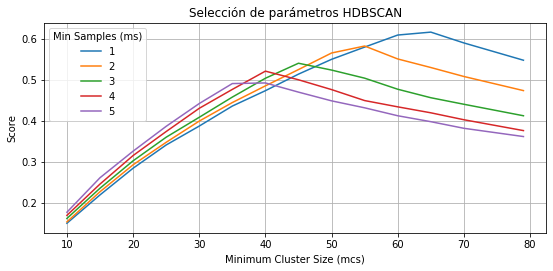

In [63]:
fig = plt.figure(figsize=(9,4))
plt.gcf().subplots_adjust(bottom=0.15)
plt.plot([10,15,20,25,30,35,40,45,50,55,60,65,70,79], penalty_score[0])
plt.plot([10,15,20,25,30,35,40,45,50,55,60,65,70,79], penalty_score[1])
plt.plot([10,15,20,25,30,35,40,45,50,55,60,65,70,79], penalty_score[2])
plt.plot([10,15,20,25,30,35,40,45,50,55,60,65,70,79], penalty_score[3])
plt.plot([10,15,20,25,30,35,40,45,50,55,60,65,70,79], penalty_score[4])
plt.grid()

plt.title('Selección de parámetros HDBSCAN')
plt.xlabel('Minimum Cluster Size (mcs)')
plt.ylabel('Score')
plt.legend(['1','2','3','4','5'], loc='upper left', title="Min Samples (ms)")

fig.savefig('data/79subjects/HDBSCAN_parameter_selection.pdf', figsize = (16,9), dpi = 300, bbox_inches = 'tight')

# The Winner is:
* _ms_ = 1
* _mcs_ = 65

In [64]:
from joblib import Memory
location = './cachedir'
memory = Memory(location, verbose=0)

ms = 1
mcs = 65

clusterer = hdbscan.HDBSCAN(
    algorithm = 'boruvka_kdtree',
    cluster_selection_method = 'leaf',
    min_samples = ms,
    min_cluster_size = mcs, 
    alpha = 1.0,
    core_dist_n_jobs = -1,
    memory = memory
    )

t0 = time.time()
clusterer.fit(latent)
exe_time = time.time() - t0

In [65]:
clusters_dict = defaultdict(list)
for k, clus in enumerate(clusterer.labels_):
    clusters_dict[clus].append(k)

n = len(set(clusters_dict))

In [66]:
len(clusterer.labels_)

768937

In [67]:
print('min samples: ',ms)
print('min cluster size: ',mcs)
print('execution time:', exe_time, '[s]')
print('n clusters',n-1)
print('n noise fibers', len(clusters_dict[-1]))
print('% noise fibers', 100*len(clusters_dict[-1])/len(latent))

min samples:  1
min cluster size:  65
execution time: 399.5863299369812 [s]
n clusters 960
n noise fibers 602475
% noise fibers 78.35167250372918


In [68]:
if not os.path.exists('data/79subjects/inter-clustered_HDB_' + str(ms) + '_' + str(mcs) + '2/'):
    os.makedirs('data/79subjects/inter-clustered_HDB_' + str(ms) + '_' + str(mcs) + '2/')

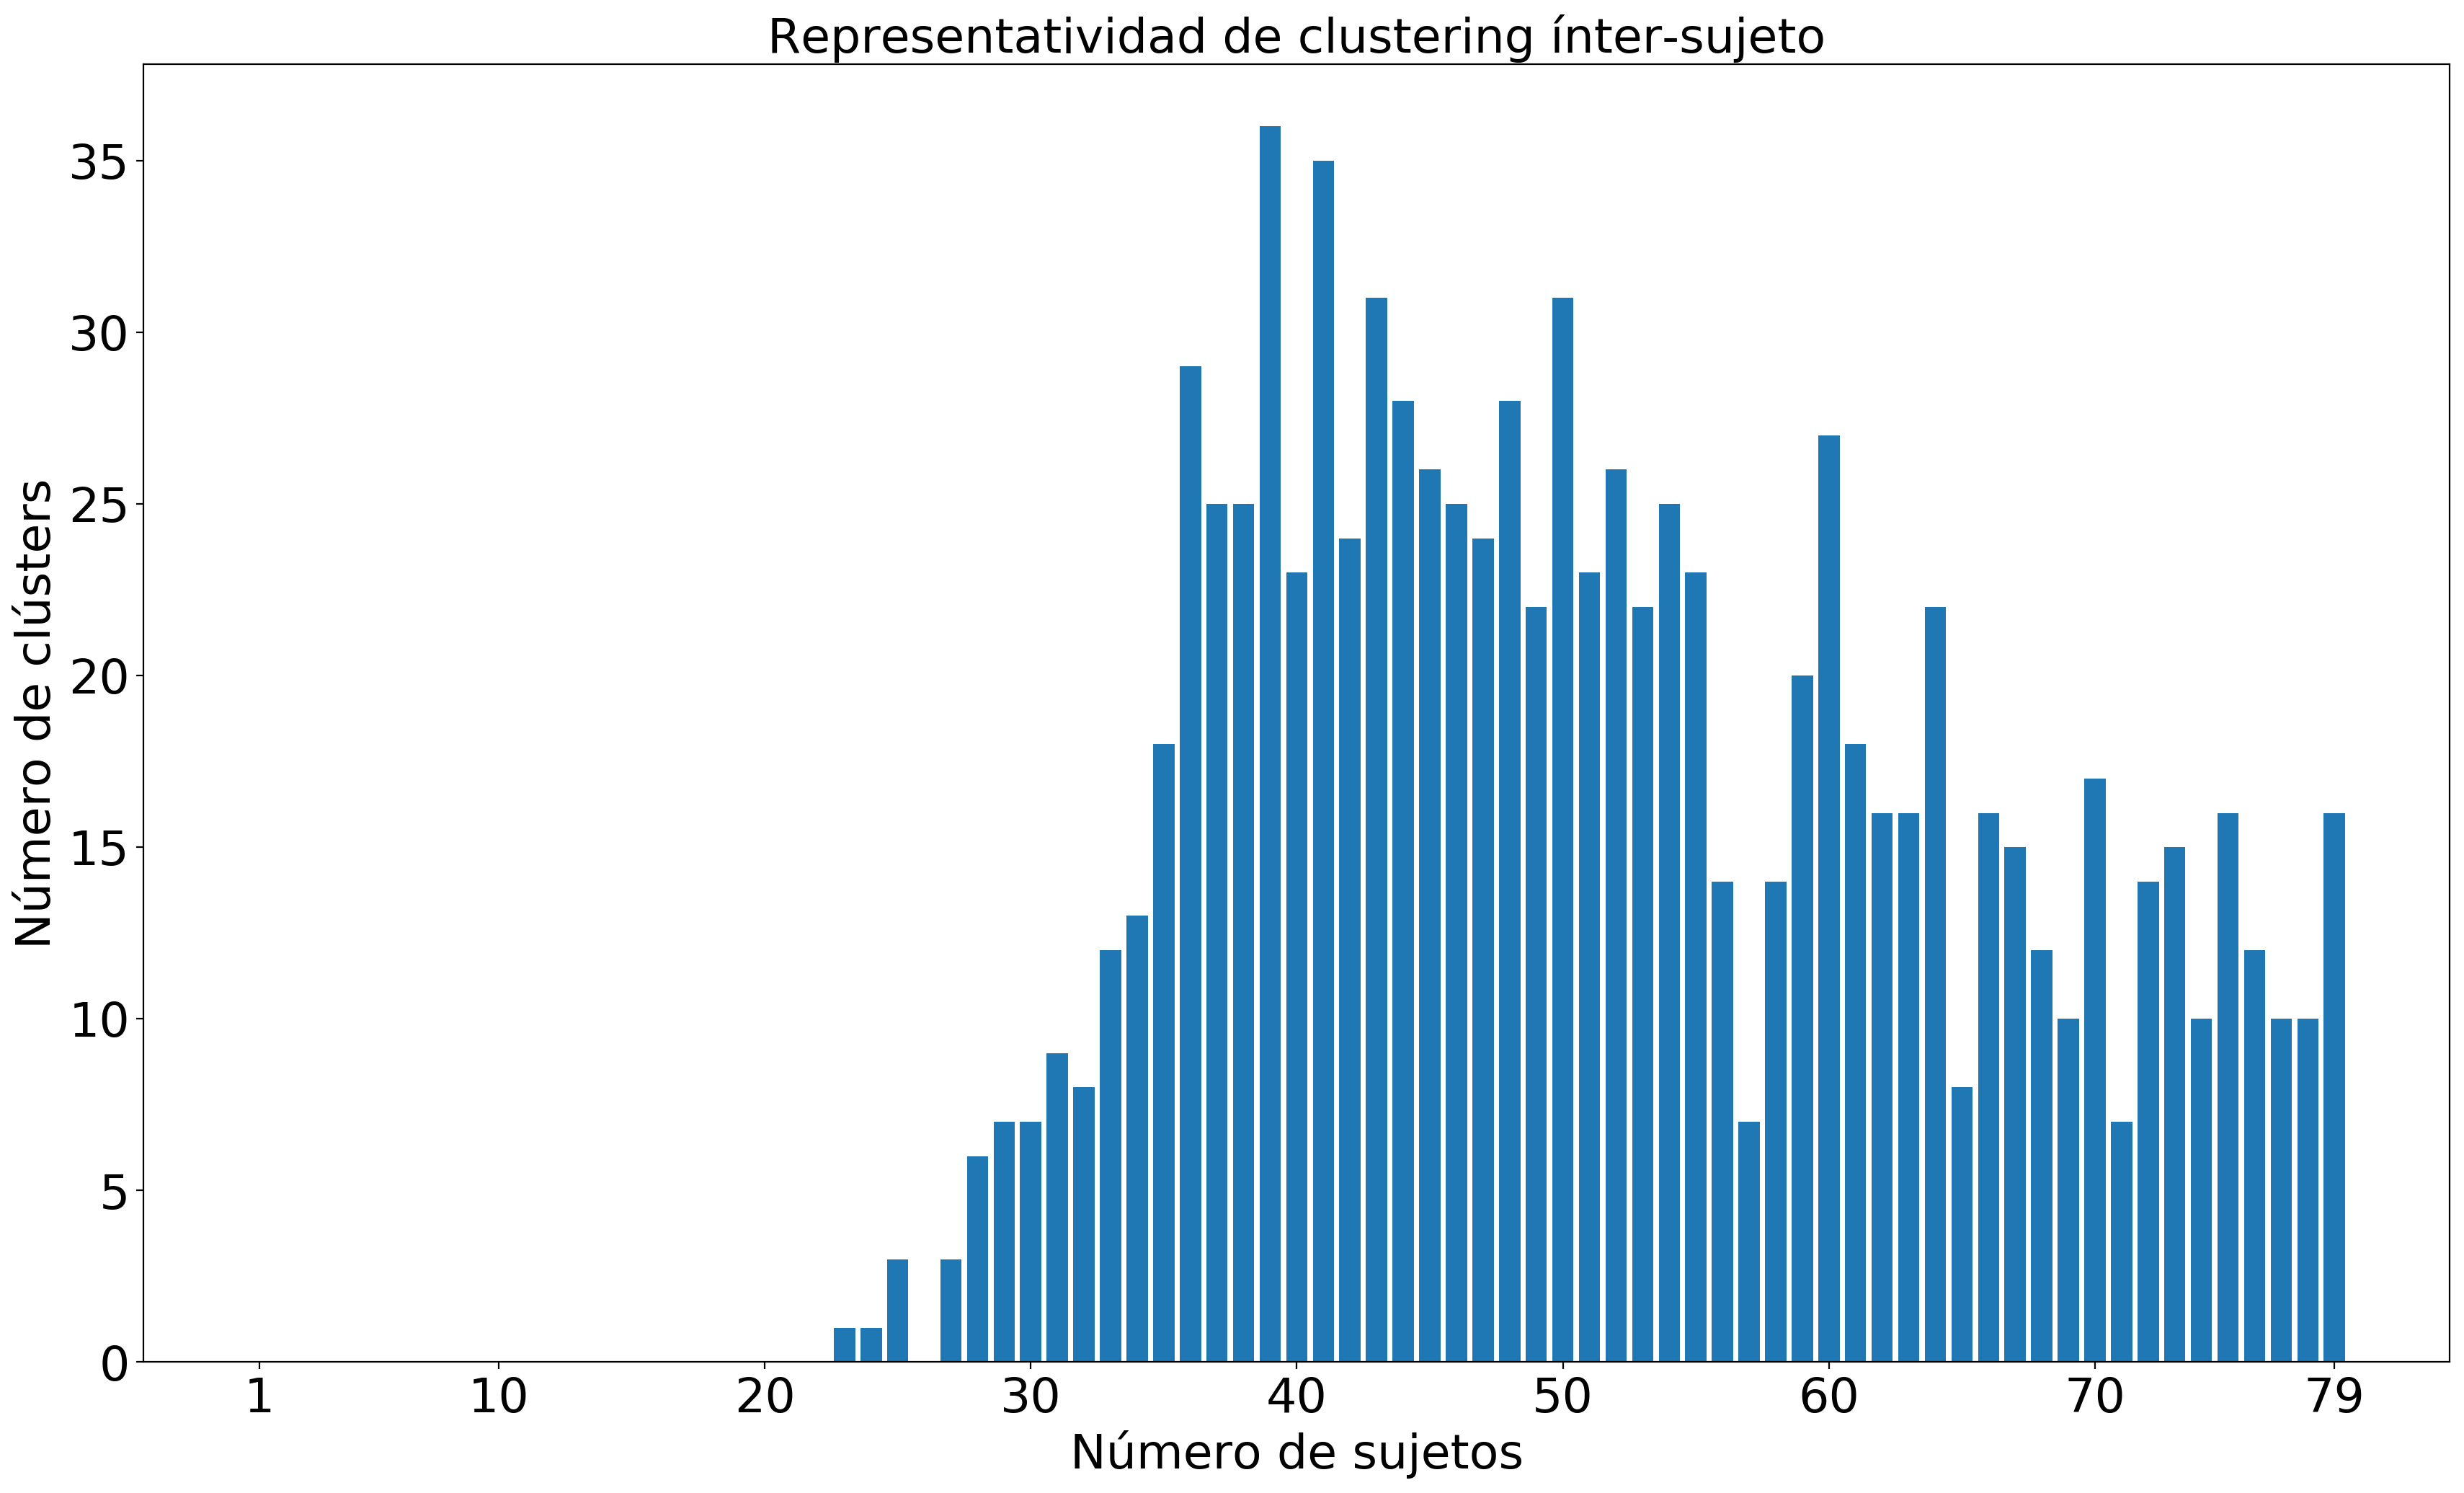

In [69]:
hist = [0]*79
for i in clusters_dict.keys():
    hist[len(set(ids[clusters_dict[i]]))-1] +=1

fig = plt.figure(figsize = (16,9), dpi = 200)
ax = fig.add_axes([0,0,1,1])
ax.bar(range(1,80), hist[:])

plt.xlabel('Número de sujetos', fontsize = 24)
plt.xticks([1,10,20,30,40,50,60,70,79], fontsize = 24)
plt.ylabel('Número de clústers', fontsize = 24)
plt.yticks(fontsize = 24)
plt.title('Representatividad de clustering ínter-sujeto', fontsize = 24)

fig.savefig('data/79subjects/inter-clustered_HDB_' + str(ms) + '_' + str(mcs) + '2/represent.pdf',dpi=300, bbox_inches = 'tight')

In [80]:
keys = range(1,80)
subs_clusters = {key: [] for key in keys}
subs_centroids = {key: [] for key in keys}
subs_clusters_names = {key: [] for key in keys}
valid = []

subs_thr = 70

for cluster in clusters_dict.keys():
    if cluster == -1:
        continue
    
    subs = set(ids[clusters_dict[cluster]])
    
    if len(subs) < subs_thr:
        continue
    
    valid.append('a')
    
    for sub in subs:
        subs_clusters_names[sub].append('cluster_' + str(cluster))
    
    subs_temp = {key: [] for key in subs}
    subs_centroid_temp = {key: [] for key in subs}

    for centroid in clusters_dict[cluster]:
        subs_centroid_temp[ids[centroid]].append(all_centroids[centroid])
        
        for fiber in all_data[centroid]:
            subs_temp[ids[centroid]].append(fiber)
    
    for sub in subs_temp.keys():
        if subs_centroid_temp[sub] != []:
            subs_centroids[sub].append(subs_centroid_temp[sub])
        if subs_temp[sub] != []:
            subs_clusters[sub].append(subs_temp[sub])
            

In [81]:
len(valid)

126

In [82]:
n_clusters = 0
n_fibers = 0

for sub in subs_clusters.keys():
    n_clusters += len(subs_clusters[sub])
    n_fibers += len(np.concatenate(subs_clusters[sub]))
    
print('Finalmente, restan ' + str(n_clusters) + ' clusters')
print('Correspondientes a ' + str(n_fibers) + ' fibras')

Finalmente, restan 9377 clusters
Correspondientes a 3750707 fibras


In [83]:
inter_clusters_names = []

for cluster in clusters_dict.keys():
    if cluster == -1:
        continue
    inter_clusters_names.append('cluster_' + str(cluster))

In [86]:
paleta = random_palette(n-1)
write_hie('data/79subjects/inter-clustered_HDB_' + str(ms) + '_' + str(mcs) + '2/HDB_' + str(ms) + '_' + str(mcs) + '.hie', inter_clusters_names, paleta)

In [87]:
import os

inter_path = 'data/79subjects/inter-clustered_HDB_' + str(ms) + '_' + str(mcs) + '2/'

for sub in subs_clusters.keys():
    if sub < 10:
        name = '00' + str(sub)
    else:
        name = '0' + str(sub)
    
    if not os.path.exists(inter_path + name):
        os.makedirs(inter_path + name)
    
    bt3.write_bundle_severalbundles(inter_path + name + '/clusters.bundles', subs_clusters[sub], subs_clusters_names[sub])
    bt3.write_bundle_severalbundles(inter_path + name + '/centroids.bundles', subs_centroids[sub], subs_clusters_names[sub])

## Inter-subject cluster alignment
* Take all the centroids in an inter-subject cluster.
* Align all the fibers with respect to the first one.
* Calculate the centroid.
* Save as centroid of the inter-subject cluster.
* Repeat for every cluster ( _HDB_centroids.bundles_ )

In [88]:
from dipy.segment.metric import mdf
from dipy.segment.metric import dist
from dipy.segment.metric import EuclideanMetric

def align_cluster(cluster, ref):
    
    aligned_cluster = []
    
    for fiber in cluster:
        d = dist(EuclideanMetric(), fiber, ref)/21
        f = mdf(fiber, ref)
        
        if f < d:
            aligned_cluster.append(fiber[::-1])
            
        else:
            aligned_cluster.append(fiber)
            
    return aligned_cluster

In [89]:
hdb_centroids = []
hdb_names = []

for k, v in clusters_dict.items():
    if k == -1:
        continue
    
    inter_centroids = all_centroids[v]
    aligned_inter_centroids = align_cluster(inter_centroids, inter_centroids[0])
    centroid = np.mean(aligned_inter_centroids, axis = 0)
    
    hdb_centroids.append([centroid])
    hdb_names.append('cluster_' + str(k))

In [91]:
bt3.write_bundle_severalbundles(inter_path + 'HDB_' + str(ms) + '_' + str(mcs) + '_centroids.bundles', hdb_centroids, hdb_names)

## Visualización

In [83]:
for z in range(n):
    #Número de cluster a visualizar
    idx = z
    
    subs_thr = 70

    #Indices de centroides intra-sujeto correspondientes al cluster
    cluster_idx = clusters_dict[idx]

    #Centroides correspondientes al cluster
    inter_cluster = all_centroids[cluster_idx]

    #Identificadores de centroides correspondientes al cluster
    clusters_ids = ids[cluster_idx]

    #Paleta de colores (1 por sujeto)
    colormap = actor.create_colormap(np.arange(len(set(clusters_ids))))

    #Mapa de colores (1 por centroide)
    colormap_full = np.ones((len(inter_cluster), 3))

    #Se asigna el mismo color a centroides que vienen del mismo sujeto
    for sub, color in zip(set(clusters_ids), colormap):
        colormap_full[np.where(clusters_ids == sub)] = color*10

    #Visualización
    interactive = True

    if not os.path.exists('images_hdb_' + str(ms) + '_' + str(mcs) + '/' + str(idx)):
        os.makedirs('images_hdb_' + str(ms) + '_' + str(mcs) + '/' + str(idx))

    ren = window.Scene()
    window.Scene().clear
    ren.SetBackground(1, 1, 1)
    ren.add(actor.streamtube(inter_cluster, colormap_full, linewidth = 0.2))
    # ren.set_camera(position=(-4.04,270.91,101.11),focal_point=(0.64,52.22,-50.08),view_up=(0.01,0.57,-0.82))
    window.snapshot(ren, size=(1920,1080), fname='images_hdb_' + str(ms) + '_' + str(mcs) + '/' + str(idx) + '/inter-cluster.png')
    # window.record(ren, size=(800, 600), n_frames = 10, path_numbering = True, stereo = 'interlaced', verbose = True)
    # if interactive:
    #     window.show(ren, reset_camera = False)

    lakitu = ren.get_camera()

    subs = list(set(ids[clusters_dict[idx]]))

    masks = []
    if len(subs) >= subs_thr:
        for indice, sub in enumerate(subs):
            a = np.array(clusters_dict[idx])
            mask = np.array(ids[clusters_dict[idx]] == sub)
            centroids = a[mask]

            temp = np.empty([0,21,3])
            temp_centroid = np.empty([0,21,3])

            for centroid in centroids:
                temp = np.append(temp, all_data[centroid], axis = 0)
                temp_centroid = np.append(temp_centroid, all_centroids[centroid].reshape([1,21,3]), axis = 0)

            ren = window.Scene()
            window.Scene().clear
            ren.SetBackground(1, 1, 1)
            ren.add(actor.streamtube(temp, np.tile(colormap[indice]*10, len(temp)).reshape(len(temp),3), linewidth = 0.1, opacity = 0.05))
            ren.add(actor.streamtube(temp_centroid, np.tile(colormap[indice]*10, len(temp_centroid)).reshape(len(temp_centroid),3), linewidth = 0.2))
            ren.set_camera(position=lakitu[0],focal_point=lakitu[1],view_up=lakitu[2])
            window.snapshot(ren, size=(1920,1080), fname='images_hdb_' + str(ms) + '_' + str(mcs) + '/' + str(idx) + '/' + str(sub) + '.png')

    else:
        print("Cantidad de sujetos insuficiente!")

Cantidad de sujetos insuficiente!
Cantidad de sujetos insuficiente!
Cantidad de sujetos insuficiente!
Cantidad de sujetos insuficiente!
Cantidad de sujetos insuficiente!
Cantidad de sujetos insuficiente!
Cantidad de sujetos insuficiente!
Cantidad de sujetos insuficiente!
Cantidad de sujetos insuficiente!
Cantidad de sujetos insuficiente!
Cantidad de sujetos insuficiente!
Cantidad de sujetos insuficiente!
Cantidad de sujetos insuficiente!
Cantidad de sujetos insuficiente!
Cantidad de sujetos insuficiente!
Cantidad de sujetos insuficiente!
Cantidad de sujetos insuficiente!
Cantidad de sujetos insuficiente!
Cantidad de sujetos insuficiente!
Cantidad de sujetos insuficiente!
Cantidad de sujetos insuficiente!
Cantidad de sujetos insuficiente!
Cantidad de sujetos insuficiente!
Cantidad de sujetos insuficiente!
Cantidad de sujetos insuficiente!
Cantidad de sujetos insuficiente!
Cantidad de sujetos insuficiente!
Cantidad de sujetos insuficiente!
Cantidad de sujetos insuficiente!
Cantidad de su

Cantidad de sujetos insuficiente!
Cantidad de sujetos insuficiente!
Cantidad de sujetos insuficiente!
Cantidad de sujetos insuficiente!
Cantidad de sujetos insuficiente!
Cantidad de sujetos insuficiente!
Cantidad de sujetos insuficiente!
Cantidad de sujetos insuficiente!
Cantidad de sujetos insuficiente!
Cantidad de sujetos insuficiente!
Cantidad de sujetos insuficiente!
Cantidad de sujetos insuficiente!
Cantidad de sujetos insuficiente!
Cantidad de sujetos insuficiente!
Cantidad de sujetos insuficiente!
Cantidad de sujetos insuficiente!
Cantidad de sujetos insuficiente!
Cantidad de sujetos insuficiente!
Cantidad de sujetos insuficiente!
Cantidad de sujetos insuficiente!
Cantidad de sujetos insuficiente!
Cantidad de sujetos insuficiente!
Cantidad de sujetos insuficiente!
Cantidad de sujetos insuficiente!
Cantidad de sujetos insuficiente!
Cantidad de sujetos insuficiente!
Cantidad de sujetos insuficiente!
Cantidad de sujetos insuficiente!
Cantidad de sujetos insuficiente!
Cantidad de su

Cantidad de sujetos insuficiente!
Cantidad de sujetos insuficiente!
Cantidad de sujetos insuficiente!
Cantidad de sujetos insuficiente!
Cantidad de sujetos insuficiente!
Cantidad de sujetos insuficiente!
Cantidad de sujetos insuficiente!
Cantidad de sujetos insuficiente!
Cantidad de sujetos insuficiente!
Cantidad de sujetos insuficiente!
Cantidad de sujetos insuficiente!
Cantidad de sujetos insuficiente!
Cantidad de sujetos insuficiente!
Cantidad de sujetos insuficiente!
Cantidad de sujetos insuficiente!
Cantidad de sujetos insuficiente!
Cantidad de sujetos insuficiente!
Cantidad de sujetos insuficiente!
Cantidad de sujetos insuficiente!
Cantidad de sujetos insuficiente!
Cantidad de sujetos insuficiente!
Cantidad de sujetos insuficiente!
Cantidad de sujetos insuficiente!
Cantidad de sujetos insuficiente!
Cantidad de sujetos insuficiente!
Cantidad de sujetos insuficiente!
Cantidad de sujetos insuficiente!
Cantidad de sujetos insuficiente!
Cantidad de sujetos insuficiente!
Cantidad de su

Cantidad de sujetos insuficiente!
Cantidad de sujetos insuficiente!
Cantidad de sujetos insuficiente!
Cantidad de sujetos insuficiente!
Cantidad de sujetos insuficiente!
Cantidad de sujetos insuficiente!
Cantidad de sujetos insuficiente!
Cantidad de sujetos insuficiente!
Cantidad de sujetos insuficiente!
Cantidad de sujetos insuficiente!
Cantidad de sujetos insuficiente!
Cantidad de sujetos insuficiente!
Cantidad de sujetos insuficiente!
Cantidad de sujetos insuficiente!
Cantidad de sujetos insuficiente!
Cantidad de sujetos insuficiente!
Cantidad de sujetos insuficiente!
Cantidad de sujetos insuficiente!
Cantidad de sujetos insuficiente!
Cantidad de sujetos insuficiente!
Cantidad de sujetos insuficiente!
Cantidad de sujetos insuficiente!
Cantidad de sujetos insuficiente!
Cantidad de sujetos insuficiente!
Cantidad de sujetos insuficiente!
Cantidad de sujetos insuficiente!
Cantidad de sujetos insuficiente!
Cantidad de sujetos insuficiente!
Cantidad de sujetos insuficiente!
Cantidad de su

ValueError: zero-size array to reduction operation minimum which has no identity

In [168]:
idx = 12

cent = np.mean(np.array(subs_clusters[1][idx]), axis = 0)

cent = cent.reshape(1,21,3)

np.shape(cent)

jaja = subs_clusters[2][idx]
# jaja = np.append(np.array(subs_clusters[1][idx]), cent, axis = 0)
# np.shape(jaja)

# display(cent)
display(jaja)

/home/fondecyt-1190701/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:46: DeprecationWarning: Renderer() deprecated, Please use Scene()instead

* deprecated from version: 0.2.0
* Will raise <class 'fury.deprecator.ExpiredDeprecationError'> as of version: 0.6.0


In [51]:
clusters_dict.keys()

dict_keys([-1, 44, 1425, 1448, 1552, 1512, 1347, 361, 1474, 1442, 1470, 744, 1012, 1409, 60, 339, 1506, 1000, 1481, 162, 1174, 333, 1435, 1378, 159, 939, 1500, 517, 107, 195, 1373, 2040, 345, 454, 685, 771, 15, 72, 1583, 817, 1080, 377, 1664, 1005, 1427, 156, 976, 1441, 71, 1426, 938, 530, 634, 351, 2075, 589, 741, 1008, 2223, 449, 1014, 1593, 1109, 1598, 1571, 1638, 1157, 616, 2090, 743, 851, 39, 1499, 1356, 1401, 1333, 1144, 1152, 1301, 1586, 37, 2194, 1681, 1341, 47, 871, 1268, 922, 1682, 1676, 562, 1688, 1163, 1350, 1691, 1444, 545, 1678, 1456, 1443, 1686, 1136, 1510, 1329, 1748, 815, 564, 2303, 1454, 196, 1105, 1494, 1151, 692, 1801, 115, 408, 1173, 829, 993, 2167, 985, 2024, 1397, 849, 40, 150, 2133, 2122, 401, 2176, 1753, 1495, 445, 844, 35, 574, 1504, 1388, 1099, 52, 200, 1437, 1587, 1428, 1318, 919, 1588, 1501, 1564, 910, 1674, 1700, 577, 581, 1779, 1969, 2048, 573, 2301, 480, 2296, 1912, 1064, 1088, 1196, 2196, 1524, 516, 1033, 1567, 561, 1189, 923, 1725, 1865, 1624, 2293, 18

In [60]:
inter_cluster = all_centroids[clusters_dict[680]]

display(inter_cluster)

/home/fondecyt-1190701/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:46: DeprecationWarning: Renderer() deprecated, Please use Scene()instead

* deprecated from version: 0.2.0
* Will raise <class 'fury.deprecator.ExpiredDeprecationError'> as of version: 0.6.0


In [480]:
np.shape(subs_clusters[1][0])

(422, 21, 3)

In [466]:
display(subs_clusters[1][0])